In [1]:
#!pip install xlsxwriter
#!pip install pandas-profiling==3.3.0

In [2]:
import pandas as pd  # Biblioteca para manipulação de dados em formato de tabela
import numpy as np  # Biblioteca para operações numéricas
from scipy import stats  # Biblioteca para estatística e análise de dados
import xlsxwriter  # Biblioteca para criar e manipular arquivos Excel
import matplotlib.pyplot as plt  # Biblioteca para criação de gráficos
import seaborn as sns  # Biblioteca para visualização de dados
from scipy.stats import chi2_contingency  # Função para calcular a estatística de qui-quadrado
import math  # Biblioteca para operações matemáticas
from pandas_profiling import ProfileReport  # Biblioteca para geração de relatórios de perfil de dados

/usr/local/lib/python3.10/dist-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/usr/local/lib/python3.10/dist-packages/visions/backends/shared/nan_handling.py:51: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def hasna(x: np.ndarray) -> bool:


In [3]:
df = pd.read_excel('CBS_CRM.xlsx', skiprows=1)

In [4]:
#definir tema global para os gráficos
sns.set_theme(
    context='talk',
    style='ticks',
    font_scale=.8,
    rc={
        'figure.figsize': (12,8)
    }
)

In [5]:
# listar os atributos e funções de um objeto, excluindo os que começam com _
def list_attributes(obj):
  return [attr for attr in obj.__dir__() if not attr.startswith('_')]

<h1><font size="4" color="#FF69B4">Exploração e tratamento de dados</font></h1>

<p><font size="3">Nesta seção, vamos explorar e tratar os dados para prepará-los para a análise. Isso inclui:

* Importação de bibliotecas necessárias
* Carregamento dos dados
* Visualização dos dados para entender a distribuição e a estrutura
* Tratamento de valores ausentes e outliers
* Transformação de variáveis para melhorar a análise.</font></p>

In [6]:
df.drop('Unnamed: 15', axis=1, inplace=True)

In [7]:
# fornece uma visão geral rápida e fácil de entender dos dados, incluindo informações sobre valores ausentes, registros duplicados, variáveis categóricas e numéricas, correlações e histogramas.
#df.profile_report()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [8]:
# Identificar e mostrar valores nulos
df_missing = (
  df.isna().sum()
  .to_frame('missing_count')
  .join((df.isna().sum() / df.shape[0]).to_frame('missing_pct'))# shape retorna tupla, com quantidade de linha e colunas
  .sort_values('missing_count', ascending=False)
)
# formatando para duas casas decimais (convertendo em porcentagem, normal seria 2f)
df_missing.style.format('{:.2%}', subset=['missing_pct'])
# somente formatando o missing_pct

,missing_count,missing_pct
REAGENDAMENTO,1637,97.79%
QTDE,1470,87.81%
DATA AGENDAMENTO,1451,86.68%
OBSERVAÇÕES,836,49.94%
HORÁRIO,373,22.28%
PROFESSOR,301,17.98%
IDADE,246,14.70%
TELEFONE,83,4.96%
SITUAÇÃO,34,2.03%
COMPARECEU,24,1.43%


In [9]:
df.head(5)

,QTDE,DATA 1º CONTATO,NOME COMPLETO,IDADE,TELEFONE,STATUS,VIA,ESTILOS,DATA AGENDAMENTO,HORÁRIO,PROFESSOR,COMPARECEU,REAGENDAMENTO,SITUAÇÃO,OBSERVAÇÕES
0,1.0,2022-01-07 00:00:00,Graziele,22,12 99614-0592,AULA EXPERIMENTAL,WHATSAPP,JAZZ FUNK,NaT,18h30,ALISSON,SIM,NaN,MATRICULADO,NaN
1,2.0,2022-01-07 00:00:00,Camila,ADULTO,11 94129-6714,INFORMAÇÕES,WHATSAPP,JAZZ,NaT,19H30,LIA,NÃO,NaN,SEMANA SOLIDÁRIA,NaN
2,3.0,2021-01-05 00:00:00,MAIARA GOUVEA,16,98841-5432,AULA EXPERIMENTAL,WHATS,K-POP,NaT,19H00,ALISSON,NÃO FICOU,NaN,NÃO RESPONDE,NaN
3,4.0,2021-01-05 00:00:00,ENIALE RAMOS QUINTINO (MÃE ELAINE),11,99124-9509,AULA EXPERIMENTAL,WHATS,JAZZ,NaT,17H00,LIA,MATRICULADO,NaN,MATRICULADO,NaN
4,5.0,2022-01-07 00:00:00,Bia,ADULTO,12 98129-7939,INFORMAÇÕES,WHATSAPP,MODALIDADES,NaT,-,-,NÃO,NaN,SEMANA SOLIDÁRIA,NaN


In [10]:
#converter em string para alterações
df['DATA 1º CONTATO'] = df['DATA 1º CONTATO'].astype(str)

In [11]:
 #dropar nulos
df.dropna(subset=['DATA 1º CONTATO'], inplace=True)

In [12]:
#corrigir valores que não estão no formato
df = df[df['DATA 1º CONTATO'].astype(str).str.replace(' |-', '', regex=True).ne('')]

In [13]:
#corrigindo inconsistencias
df['DATA 1º CONTATO'] = df['DATA 1º CONTATO'].str.replace('223', '2023').str.replace('2012', '2021')

<ipython-input-13-32940162d311>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['DATA 1º CONTATO'] = df['DATA 1º CONTATO'].str.replace('223', '2023').str.replace('2012', '2021')


In [14]:
# dropar nulos
df = df[pd.to_datetime(df['DATA 1º CONTATO'], errors='coerce').notna()]
#converter em formato date
df['DATA 1º CONTATO'] = pd.to_datetime(df['DATA 1º CONTATO'], errors='coerce').dt.date

In [15]:
# Excluir valores nulos
df.dropna(subset=['NOME COMPLETO'], inplace=True)
# Remover caracteres especiais
df['NOME COMPLETO'] = df['NOME COMPLETO'].str.replace(r'[^\w\s]', '', regex=True)
df['NOME COMPLETO'] = df['NOME COMPLETO'].str.strip()
df['NOME COMPLETO'] = df['NOME COMPLETO'].str.upper()

In [16]:
# converte a coluna idade para numerico
df['IDADE'] = pd.to_numeric(df['IDADE'], errors='coerce')

In [17]:
# Converter valores numéricos e '%-%' para float, e strings para NaN
df['IDADE'] = df['IDADE'].apply(lambda x: float(x) if isinstance(x, (int, float)) else
                                      (float(x.split('-')) if isinstance(x, str) and '-' in x else np.nan))

# Preencher valores NaN com a média da coluna
df['IDADE'].fillna(df['IDADE'].mean(), inplace=True)

# Alterar para tipo inteiro
df['IDADE'] = df['IDADE'].astype(int)

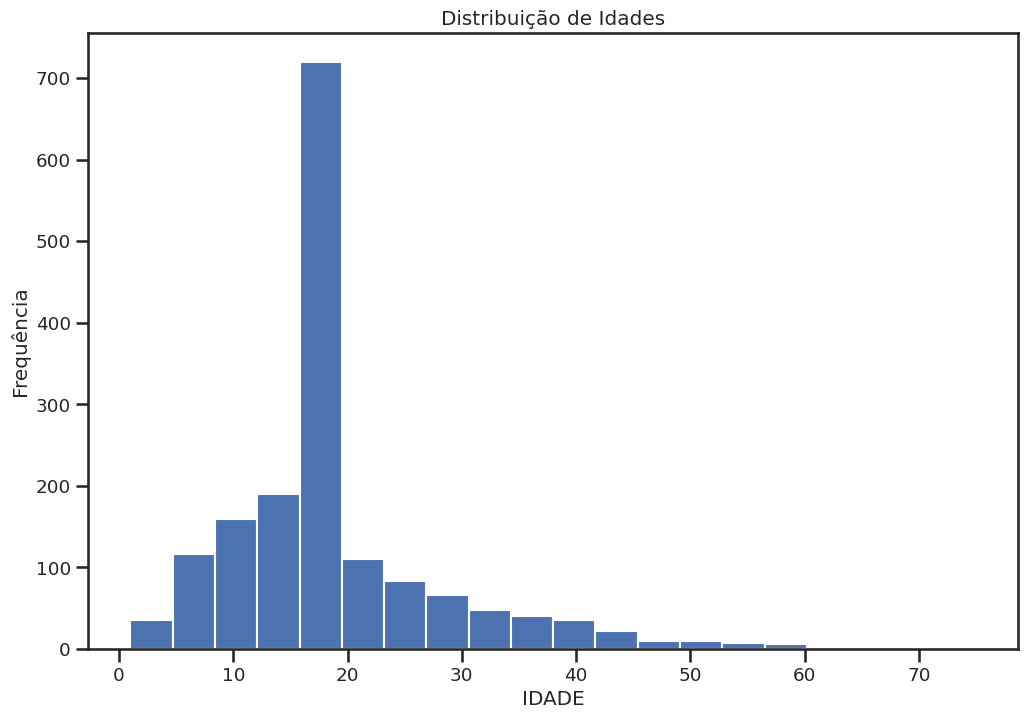

In [18]:
# Análise de distribuição de valores em 'IDADE' para verificar outliers
plt.hist(df['IDADE'], bins=20)
plt.xlabel('IDADE')
plt.ylabel('Frequência')
plt.title('Distribuição de Idades')
plt.show()

In [19]:
# Crie a coluna 'FAIXA ETARIA'
df['FAIXA ETARIA'] = df['IDADE'].apply(lambda x:
    'CRIANÇA' if x < 10 else
    'ADOLESCENTE' if x <= 15 else
    'ADULTO'
)

In [20]:
# Reordena as colunas para que 'FAIXA ETARIA' fique do lado direito de 'IDADE'
df = df[['DATA 1º CONTATO', 'NOME COMPLETO', 'IDADE', 'FAIXA ETARIA', 'TELEFONE', 'STATUS', 'VIA', 'ESTILOS', 'DATA AGENDAMENTO', 'HORÁRIO', 'PROFESSOR', 'COMPARECEU', 'REAGENDAMENTO', 'SITUAÇÃO', 'OBSERVAÇÕES']]

In [21]:
df.head()

,DATA 1º CONTATO,NOME COMPLETO,IDADE,FAIXA ETARIA,TELEFONE,STATUS,VIA,ESTILOS,DATA AGENDAMENTO,HORÁRIO,PROFESSOR,COMPARECEU,REAGENDAMENTO,SITUAÇÃO,OBSERVAÇÕES
0,2022-01-07,GRAZIELE,22,ADULTO,12 99614-0592,AULA EXPERIMENTAL,WHATSAPP,JAZZ FUNK,NaT,18h30,ALISSON,SIM,NaN,MATRICULADO,NaN
1,2022-01-07,CAMILA,19,ADULTO,11 94129-6714,INFORMAÇÕES,WHATSAPP,JAZZ,NaT,19H30,LIA,NÃO,NaN,SEMANA SOLIDÁRIA,NaN
2,2021-01-05,MAIARA GOUVEA,16,ADULTO,98841-5432,AULA EXPERIMENTAL,WHATS,K-POP,NaT,19H00,ALISSON,NÃO FICOU,NaN,NÃO RESPONDE,NaN
3,2021-01-05,ENIALE RAMOS QUINTINO MÃE ELAINE,11,ADOLESCENTE,99124-9509,AULA EXPERIMENTAL,WHATS,JAZZ,NaT,17H00,LIA,MATRICULADO,NaN,MATRICULADO,NaN
4,2022-01-07,BIA,19,ADULTO,12 98129-7939,INFORMAÇÕES,WHATSAPP,MODALIDADES,NaT,-,-,NÃO,NaN,SEMANA SOLIDÁRIA,NaN


In [22]:
# desnecessário aparecer no modelo (até poderiamos utilizar engenharia de recursos para ter uma ideia sobre a origem da pessoa pelo DDD, mas não é relevante neste caso pois possuimos o cadastro do aluno)
df['TELEFONE'] = df['TELEFONE'].apply(lambda x: '0000-0000')

In [23]:
df.head()

,DATA 1º CONTATO,NOME COMPLETO,IDADE,FAIXA ETARIA,TELEFONE,STATUS,VIA,ESTILOS,DATA AGENDAMENTO,HORÁRIO,PROFESSOR,COMPARECEU,REAGENDAMENTO,SITUAÇÃO,OBSERVAÇÕES
0,2022-01-07,GRAZIELE,22,ADULTO,0000-0000,AULA EXPERIMENTAL,WHATSAPP,JAZZ FUNK,NaT,18h30,ALISSON,SIM,NaN,MATRICULADO,NaN
1,2022-01-07,CAMILA,19,ADULTO,0000-0000,INFORMAÇÕES,WHATSAPP,JAZZ,NaT,19H30,LIA,NÃO,NaN,SEMANA SOLIDÁRIA,NaN
2,2021-01-05,MAIARA GOUVEA,16,ADULTO,0000-0000,AULA EXPERIMENTAL,WHATS,K-POP,NaT,19H00,ALISSON,NÃO FICOU,NaN,NÃO RESPONDE,NaN
3,2021-01-05,ENIALE RAMOS QUINTINO MÃE ELAINE,11,ADOLESCENTE,0000-0000,AULA EXPERIMENTAL,WHATS,JAZZ,NaT,17H00,LIA,MATRICULADO,NaN,MATRICULADO,NaN
4,2022-01-07,BIA,19,ADULTO,0000-0000,INFORMAÇÕES,WHATSAPP,MODALIDADES,NaT,-,-,NÃO,NaN,SEMANA SOLIDÁRIA,NaN


In [24]:
df['STATUS'].unique()

array(['AULA EXPERIMENTAL', 'INFORMAÇÕES', 'AULA ESPERIMENTAL',
       'INFORMAÇÕES ', 'CAPTAÇÃO', 'COREOGRAFIA', 'AULA AVULSA',
       'INFORMACOES', 'INFORMAÇÃO', 'INFORMAÇOES', nan], dtype=object)

In [25]:
# Padronize 'INFORMAÇÕES'
df['STATUS'] = df['STATUS'].str.replace('INFORMAÇÕES ', 'INFORMAÇÕES')
df['STATUS'] = df['STATUS'].str.replace('INFORMACOES', 'INFORMAÇÕES')
df['STATUS'] = df['STATUS'].str.replace('INFORMAÇÃO', 'INFORMAÇÕES')
df['STATUS'] = df['STATUS'].str.replace('INFORMAÇOES', 'INFORMAÇÕES')
df['STATUS'] = df['STATUS'].str.replace('INFORMAÇÕES', 'CAPTAÇÃO')
# Substitua 'AULA AVULSA' por 'EXPERIMENTAL'
df['STATUS'] = df['STATUS'].str.replace('AULA AVULSA', 'EXPERIMENTAL')
df['STATUS'] = df['STATUS'].str.replace('AULA EXPERIMENTAL', 'EXPERIMENTAL')

# Padronize 'AULA ESPERIMENTAL'
df['STATUS'] = df['STATUS'].str.replace('AULA ESPERIMENTAL', 'EXPERIMENTAL')
df['STATUS'] = df['STATUS'].str.replace('AULA AULA EXPERIMENTAL', 'EXPERIMENTAL')
df['STATUS'] = df['STATUS'].str.replace('COREOGRAFIA', 'EXPERIMENTAL')


# Excluir nulos
df = df.dropna(subset=['STATUS'])

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1666 entries, 0 to 1673
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   DATA 1º CONTATO   1666 non-null   object        
 1   NOME COMPLETO     1666 non-null   object        
 2   IDADE             1666 non-null   int64         
 3   FAIXA ETARIA      1666 non-null   object        
 4   TELEFONE          1666 non-null   object        
 5   STATUS            1666 non-null   object        
 6   VIA               1666 non-null   object        
 7   ESTILOS           1662 non-null   object        
 8   DATA AGENDAMENTO  222 non-null    datetime64[ns]
 9   HORÁRIO           1298 non-null   object        
 10  PROFESSOR         1371 non-null   object        
 11  COMPARECEU        1648 non-null   object        
 12  REAGENDAMENTO     37 non-null     object        
 13  SITUAÇÃO          1637 non-null   object        
 14  OBSERVAÇÕES       838 no

In [27]:
df['VIA'].unique()

array(['WHATSAPP', 'WHATS', 'INSTAGRAM', 'TELEFONE', 'PESSOALMENTE',
       'PRESENCIAL', 'PRESENCIAL ', 'SITE', 'VALE AULA', 'FACEBOOK',
       'MESSENGER', 'MAE JÁ É ALUNA', 'ALUNA'], dtype=object)

In [28]:
#padrozniar
df['VIA'] = df['VIA'].str.replace('WHATSAPPAPP', 'WHATSAPP')
df['VIA'] = df['VIA'].str.replace('WHATSAPP', 'WHATSAPP')
df['VIA'] = df['VIA'].str.replace('PESSOALMENTE', 'PRESENCIAL')
df['VIA'] = df['VIA'].str.replace('VALE ', 'PRESENCIAL')
df['VIA'] = df['VIA'].str.replace('MAE JÁ É ALUNA', 'PRESENCIAL')
df['VIA'] = df['VIA'].str.replace('ALUNA', 'PRESENCIAL')
df['VIA'] = df['VIA'].str.replace('MESSENGER', 'FACEBOOK')
df['VIA'] = df['VIA'].str.replace('PRESENCIALAULA', 'PRESENCIAL')
df['VIA'] = df['VIA'].str.replace('PRESENCIAL ', 'PRESENCIAL')

In [29]:
df['VIA'].unique()

array(['WHATSAPP', 'WHATS', 'INSTAGRAM', 'TELEFONE', 'PRESENCIAL', 'SITE',
       'FACEBOOK'], dtype=object)

In [30]:
# Padronização
df['ESTILOS'] = df['ESTILOS'].str.replace('JAZZ FUNK ', 'JAZZ FUNK')
df['ESTILOS'] = df['ESTILOS'].str.replace('JAZZ FUNKINICIANTE', 'JAZZ FUNK')
df['ESTILOS'] = df['ESTILOS'].str.replace('JAZZ FUNKINTERMEDIARIO', 'JAZZ FUNK')
df['ESTILOS'] = df['ESTILOS'].str.replace('JAZZFUNK', 'JAZZ FUNK')


df['ESTILOS'] = df['ESTILOS'].str.replace('JAZZ ', 'JAZZ')
df['ESTILOS'] = df['ESTILOS'].str.replace('JAZZ INICIANTE', 'JAZZ')
df['ESTILOS'] = df['ESTILOS'].str.replace('Jazz', 'JAZZ')
df['ESTILOS'] = df['ESTILOS'].str.replace('Jazz iniciante', 'JAZZ')
df['ESTILOS'] = df['ESTILOS'].str.replace('JAZZINICIANTE', 'JAZZ')
df['ESTILOS'] = df['ESTILOS'].str.replace('JAZZ iniciante', 'JAZZ')
df['ESTILOS'] = df['ESTILOS'].str.replace('JAZZiniciante', 'JAZZ')

df['ESTILOS'] = df['ESTILOS'].str.replace('AULA DE BREAK', 'DANÇAS URBANAS')
df['ESTILOS'] = df['ESTILOS'].str.replace('JAZZE D URBANAS', 'DANÇAS URBANAS')


In [31]:
df['ESTILOS'] = df['ESTILOS'].str.replace(r'[^\w\s]+', '', regex=True).str.replace('\s+', ' ', regex=True).str.strip()

In [32]:
df['ESTILOS'] = df['ESTILOS'].str.replace(r'BALLET.*|KPOPBALLET.*|BALLEYT', 'BALLET CLÁSSICO', regex=True)
df['ESTILOS'] = df['ESTILOS'].str.replace(r'KPOP.*|K POP INTERMEDIARIO|K POP INICIANTE|kpop|K Pop|Kpop|K POP', 'K-POP', regex=True)
df['ESTILOS'] = df['ESTILOS'].str.replace(r'SAPATEADO.*|Sapateado', 'SAPATEADO', regex=True)
df['ESTILOS'] = df['ESTILOS'].str.replace(r'CONTEMPORANEO.*', 'CONTEMPORÂNEO', regex=True)

In [33]:
# Contar a frequência de cada valor em ESTILO
value_counts = df['ESTILOS'].value_counts()

In [34]:
df.head(3)

,DATA 1º CONTATO,NOME COMPLETO,IDADE,FAIXA ETARIA,TELEFONE,STATUS,VIA,ESTILOS,DATA AGENDAMENTO,HORÁRIO,PROFESSOR,COMPARECEU,REAGENDAMENTO,SITUAÇÃO,OBSERVAÇÕES
0,2022-01-07,GRAZIELE,22,ADULTO,0000-0000,EXPERIMENTAL,WHATSAPP,JAZZFUNK,NaT,18h30,ALISSON,SIM,NaN,MATRICULADO,NaN
1,2022-01-07,CAMILA,19,ADULTO,0000-0000,CAPTAÇÃO,WHATSAPP,JAZZ,NaT,19H30,LIA,NÃO,NaN,SEMANA SOLIDÁRIA,NaN
2,2021-01-05,MAIARA GOUVEA,16,ADULTO,0000-0000,EXPERIMENTAL,WHATS,K-POP,NaT,19H00,ALISSON,NÃO FICOU,NaN,NÃO RESPONDE,NaN


In [35]:
# Selecionar os 3 valores mais frequentes
top_3_values = value_counts.nlargest(3).index.tolist()

In [36]:
top_3_values

['DANÇAS URBANAS', 'JAZZ', 'JAZZFUNK']

In [37]:
# Padronizar os valores que não são "JAZZFUNK", "JAZZ", "K-POP", "SAPATEADO", "DANÇAS URBANAS", "CONTEMPORÂNEO" e "BALLET CLÁSSICO" e distribuir igualitariamente entre estes os 3 valores que mais aparecem
df['ESTILOS'] = np.where(df['ESTILOS'].isin(['JAZZFUNK', 'JAZZ', 'K-POP', 'SAPATEADO', 'DANÇAS URBANAS', 'CONTEMPORÂNEO', 'BALLET CLÁSSICO']),
                        df['ESTILOS'],
                        np.random.choice(top_3_values))

In [38]:
df['DATA AGENDAMENTO'] = df['DATA AGENDAMENTO'].astype(str)

In [39]:
# Preencha os valores vazios com "Não agendou"
df['DATA AGENDAMENTO'].fillna('Não agendou', inplace=True)


# Altere o ano de 2032 para 2023
df['DATA AGENDAMENTO'] = df['DATA AGENDAMENTO'].apply(lambda x: '2023-' + x[5:] if x and x.startswith('2032') else x)

In [40]:
# Renomear a coluna HORÁRIO para TURNO
df = df.rename(columns={'HORÁRIO': 'TURNO'})

In [41]:
# função que converte um horário em um turno do dia
def convert_horario(x):
    if isinstance(x, str):
        if '-' in x or x[:2].isalpha():
            return 'Unknown'
        else:
            hour = ''.join(filter(str.isdigit, x))
            if hour:
                hour = int(hour)
                if 6 <= hour <= 12:
                    return 'MANHA'
                elif 12 <= hour <= 18:
                    return 'TARDE'
                else:
                    return 'NOITE'
            else:
                return 'Unknown'
    else:
        return 'Unknown'

df['TURNO'] = df['TURNO'].apply(convert_horario)

In [42]:
# Substituição dos valores 'Unknown' pela moda
moda_turno = df['TURNO'].mode()[0]
df['TURNO'] = df['TURNO'].replace('Unknown', moda_turno)

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1666 entries, 0 to 1673
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   DATA 1º CONTATO   1666 non-null   object
 1   NOME COMPLETO     1666 non-null   object
 2   IDADE             1666 non-null   int64 
 3   FAIXA ETARIA      1666 non-null   object
 4   TELEFONE          1666 non-null   object
 5   STATUS            1666 non-null   object
 6   VIA               1666 non-null   object
 7   ESTILOS           1666 non-null   object
 8   DATA AGENDAMENTO  1666 non-null   object
 9   TURNO             1666 non-null   object
 10  PROFESSOR         1371 non-null   object
 11  COMPARECEU        1648 non-null   object
 12  REAGENDAMENTO     37 non-null     object
 13  SITUAÇÃO          1637 non-null   object
 14  OBSERVAÇÕES       838 non-null    object
dtypes: int64(1), object(14)
memory usage: 272.8+ KB


In [44]:
df['PROFESSOR'].unique()

array(['ALISSON', 'LIA', '-', 'BIANCA', 'NICOLAS', 'FERNANDO', 'GIBELI',
       'PAOLA', nan, 'GABRIELA', 'LOUBACH', 'ALISSIN', 'ALISSON ', 'LIA ',
       'CAROL', 'ISABELLY', 'LARISSA', 'AMANDA', 'CICERO', 'ALINE',
       'ALLISON ', 'CÍCERO', 'NÃO', 'ALISSON/LARI', 'TODAS', 'NÃO ',
       'LARISSA / ALISSON', 'FELIPE'], dtype=object)

In [45]:
# Substituir variantes de nomes e preencher vazios ou inconsistentes
df['PROFESSOR'] = df['PROFESSOR'].str.replace(r'ALISSIN.*|ALISSON .*|ALLISON ', 'ALISSON', regex=True)
df['ESTILOS'] = df['ESTILOS'].str.replace('LIA ', 'LIA')

df['PROFESSOR'].fillna('NÃO INFORMADO', inplace=True)
df.loc[df['PROFESSOR'] == 'NÃO', 'PROFESSOR'] = 'NÃO INFORMADO'
df.loc[df['PROFESSOR'] == 'NÃO ', 'PROFESSOR'] = 'NÃO INFORMADO'
df.loc[df['PROFESSOR'] == '-', 'PROFESSOR'] = 'NÃO INFORMADO'
df.loc[df['PROFESSOR'] == 'TODAS', 'PROFESSOR'] = 'NÃO INFORMADO'
df.loc[df['PROFESSOR'] == 'LARISSA / ALISSON', 'PROFESSOR'] = 'NÃO INFORMADO'

In [46]:
df['COMPARECEU'].unique()

array(['SIM', 'NÃO', 'NÃO FICOU', 'MATRICULADO', 'SEM RETORNO',
       'NÃO VEIO', 'MATRICULADA', 'VEIO', '-', 'AVULSO', 'NÃO RESPONDE',
       'NÃO VEIO ', 'ENROLADA', nan, 'MATRICULADO ', 'NÃO VAI FICAR',
       'AVULSA', 'CANCELOU', 'ANO QUE VEM',
       datetime.datetime(2023, 7, 31, 0, 0),
       datetime.datetime(2023, 4, 14, 0, 0),
       datetime.datetime(2023, 4, 13, 0, 0),
       datetime.datetime(2023, 4, 24, 0, 0),
       datetime.datetime(2023, 4, 25, 0, 0),
       datetime.datetime(2023, 4, 27, 0, 0),
       datetime.datetime(2023, 4, 28, 0, 0),
       datetime.datetime(2023, 5, 3, 0, 0),
       datetime.datetime(2023, 4, 20, 0, 0),
       datetime.datetime(2023, 5, 2, 0, 0),
       datetime.datetime(2023, 5, 4, 0, 0),
       datetime.datetime(2023, 5, 5, 0, 0),
       datetime.datetime(2023, 5, 12, 0, 0),
       datetime.datetime(2023, 5, 8, 0, 0),
       datetime.datetime(2023, 5, 19, 0, 0),
       datetime.datetime(2023, 5, 17, 0, 0),
       datetime.datetime(2023, 5, 

In [47]:
# alterar para tipo string
df['COMPARECEU'] = df['COMPARECEU'].astype(str)

In [48]:
# Defina os valores que devem ser considerados como 'SIM'
valores_sim = ['SIM', 'MATRICULADO', 'MATRICULADO ', 'CONFIRMADA', 'MATRICULADA', 'VEIO', '18//05/23']

# Defina os valores que devem ser considerados como 'NÃO'
valores_nao = ['nan','SUMIU','TODAS','NÃO ', 'ANO QUE VEM', 'NÃO VAI FICAR', 'AVULSA', 'CANCELOU', '-', 'AVULSO', 'NÃO RESPONDE', 'NÃO VEIO ', 'ENROLADA', 'SEM RETORNO', 'NÃO VEIO', 'NÃO', 'NÃO FICOU']

# Converter valores de data para objetos pd.Timestamp
df['COMPARECEU'] = pd.to_datetime(df['COMPARECEU'], errors='ignore')

# Substitua os valores que conhenham 2023 por 'SIM', pois significa que marcou uma data
df['COMPARECEU'] = np.where(df['COMPARECEU'].str.startswith('2023'), 'SIM', df['COMPARECEU'])

# Substitua os valores que estão em 'valores_sim' por 'SIM'
df['COMPARECEU'] = np.where(df['COMPARECEU'].isin(valores_sim), 'SIM', df['COMPARECEU'])

# Substitua os valores que estão em 'valores_nao' por 'NÃO'
df['COMPARECEU'] = np.where(df['COMPARECEU'].isin(valores_nao), 'NÃO', df['COMPARECEU'])

In [49]:
df['REAGENDAMENTO'].unique()

array([nan, 'SIM', 'NÃO'], dtype=object)

In [50]:
#preencher os valores nulos
df['REAGENDAMENTO'].fillna('NÃO', inplace=True)

In [51]:
df['SITUAÇÃO'].unique()

array(['MATRICULADO', 'SEMANA SOLIDÁRIA', 'NÃO RESPONDE', 'QUER BOLSA',
       'DCTOS BOLSA', 'OUTRA ESCOLA', 'CONFIRMADO',
       'ESTAVA SEM DINHEIRO MARÇO', 'PORTA ABERTA', 'MATRICULADA',
       'IRMÃ DE ALUNA', 'ENROLADA, NÃO RESPONDE', 'QUER GINASTICA', '-',
       'NÃO QUER MAIS', 'COMPARECEU 10/02', '2º SEMESTRE', 'PARATY',
       'SEM DINHEIRO', 'SEM RESPOSTA', 'VAI NO  SAPATEADO',
       'NÃO VEIO 23/02', 'NÃO ATENDE', 'QUER JAZZ', 'ENTRE JAZZ E STREET',
       'FICOU SEM CARRO EM 01/03', 'ASSINAR CONTRATO',
       'NÃO VEIO 23/03 e 25/02', 'NAÕ VEIO 25/02', 'INFORMAÇÕES',
       'COMPARECEU 22/02', 'AGENDADO', 'ESPERAR MAIS',
       'COMPLICADA DE HORÁRIO', 'CHOROU NA SALA',
       'COMPARECEU CRISE ANSIEDADE', 'ENROLADA', 'COMPARECEU 03/03',
       'SEM ENERGIA', 'NÃO VEIO 02/03', 'AVULSO',
       'COMPARECEU 04/03 - VAI FAZER JAZZ 18H',
       'AMIGA MATEUS Ñ CONSEGUIU VIR', 'MORA FORA',
       'VEIO ACOMPANHAR AMIGO', 'REMARCADO VÁRIAS VEZES - ENROLADA',
       'CANCELOU',

In [52]:
# Substitui os valores na coluna 'SITUAÇÃO' com 'CONTRATADO' se contiver 'CONTRAT' ou 'MATRICULA' (expressões regulares)
df['SITUAÇÃO'] = np.where(df['SITUAÇÃO'].str.contains('CONTRAT|MATRICULA', case=False), 'MATRICULADO', df['SITUAÇÃO'])
df['SITUAÇÃO'] = np.where(df['SITUAÇÃO'].str.contains('NÃO'), 'DESISTIU', df['SITUAÇÃO'])

In [53]:
#with pd.ExcelWriter('CRM.xlsx', engine='xlsxwriter') as writer:
#    df.to_excel(writer, sheet_name='CRM', index=False)
    #df_pc.to_excel(writer, sheet_name='Plano de contas', index=False)

In [54]:
print(df.isnull().sum())

DATA 1º CONTATO       0
NOME COMPLETO         0
IDADE                 0
FAIXA ETARIA          0
TELEFONE              0
STATUS                0
VIA                   0
ESTILOS               0
DATA AGENDAMENTO      0
TURNO                 0
PROFESSOR             0
COMPARECEU            0
REAGENDAMENTO         0
SITUAÇÃO              0
OBSERVAÇÕES         828
dtype: int64


In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1666 entries, 0 to 1673
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   DATA 1º CONTATO   1666 non-null   object
 1   NOME COMPLETO     1666 non-null   object
 2   IDADE             1666 non-null   int64 
 3   FAIXA ETARIA      1666 non-null   object
 4   TELEFONE          1666 non-null   object
 5   STATUS            1666 non-null   object
 6   VIA               1666 non-null   object
 7   ESTILOS           1666 non-null   object
 8   DATA AGENDAMENTO  1666 non-null   object
 9   TURNO             1666 non-null   object
 10  PROFESSOR         1666 non-null   object
 11  COMPARECEU        1666 non-null   object
 12  REAGENDAMENTO     1666 non-null   object
 13  SITUAÇÃO          1666 non-null   object
 14  OBSERVAÇÕES       838 non-null    object
dtypes: int64(1), object(14)
memory usage: 272.8+ KB


<h1><font size="4" color="#FF69B4">Analisando proporções e correlações!</font></h1>

<p><font size="3">A partir daqui, iremos visualizar a correlação entre as variáveis relevantes para o modelo ML.</font></p>

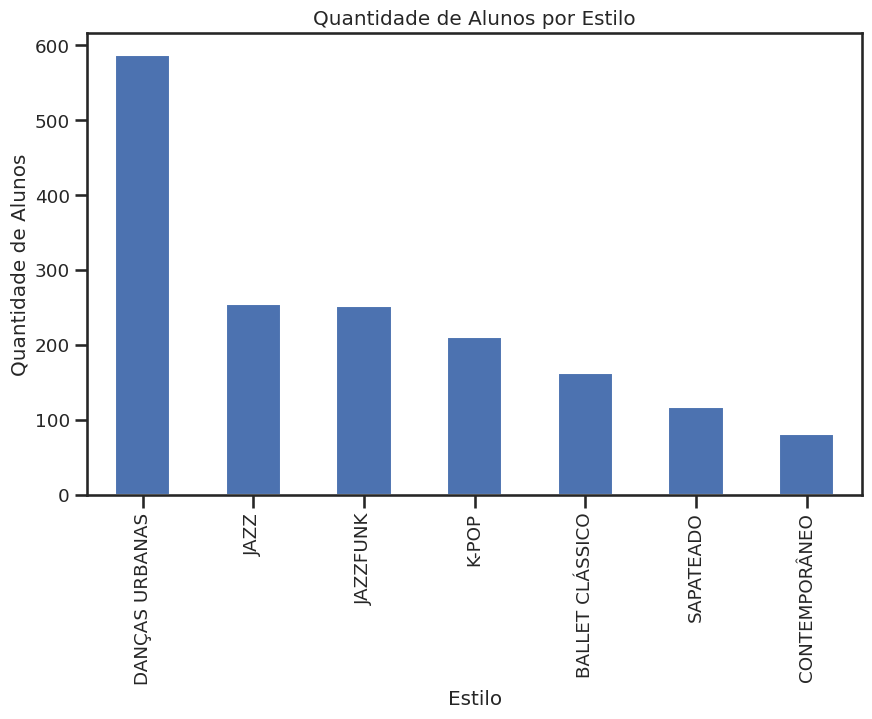

In [56]:
style_counts = df['ESTILOS'].value_counts()

# Plote o gráfico de barras
plt.figure(figsize=(10, 6))
style_counts.plot(kind='bar')
plt.title('Quantidade de Alunos por Estilo')
plt.xlabel('Estilo')
plt.ylabel('Quantidade de Alunos')
plt.show()

In [57]:
# Crie uma tabela de contingência entre as variáveis
contingency_table = pd.crosstab(df['FAIXA ETARIA'], df['ESTILOS'])

In [58]:
# Calcular o valor de Cramer's V (Medida de correlação entre FAIXA ETARIA e ESTILOS, onde 0 é nenhuma correlação e 1 é correlação perfeita)
chi2, p, dof, expected = chi2_contingency(contingency_table)
cramer_v = math.sqrt(chi2 / (df.shape[0] * df.shape[1] * (dof - 1)))

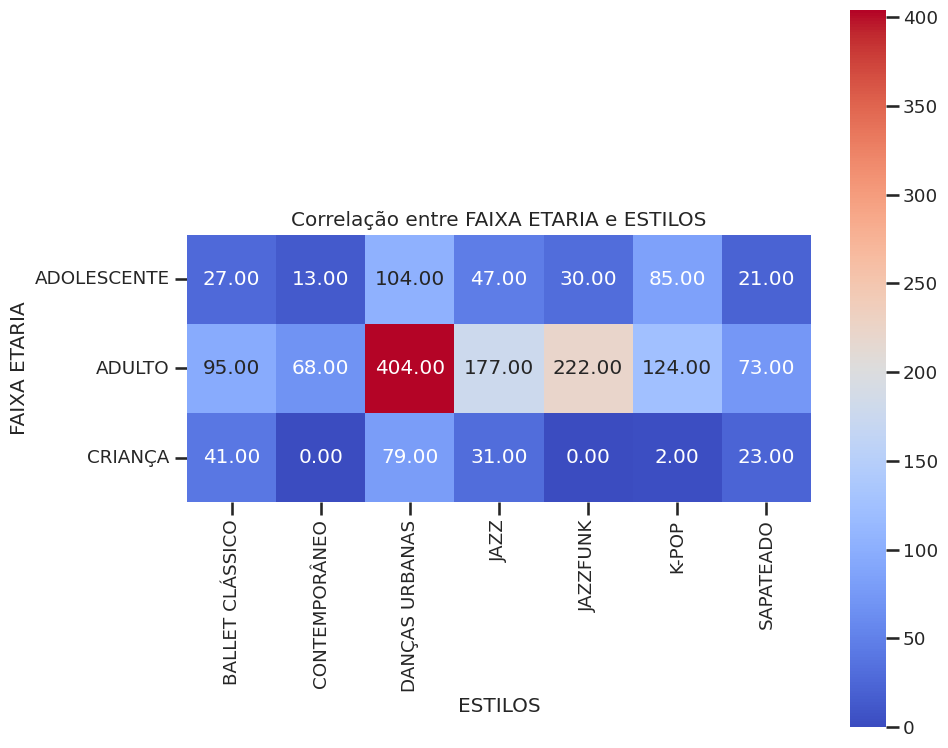

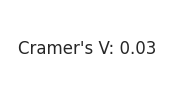

In [59]:
# Plote a matriz de correlação
plt.figure(figsize=(10, 8))
sns.heatmap(contingency_table, annot=True, cmap='coolwarm', square=True, fmt='.2f')
plt.title('Correlação entre FAIXA ETARIA e ESTILOS')
plt.tight_layout()
plt.show()

plt.figure(figsize=(2, 1))
plt.text(0.5, 0.5, f'Cramer\'s V: {cramer_v:.2f}', ha='center', va='center', fontsize=12)
plt.axis('off')
plt.show() # Cramer's V é 0.3, isso significa que há uma relação moderada entre a faixa etaria dos alunos e estilos de danças

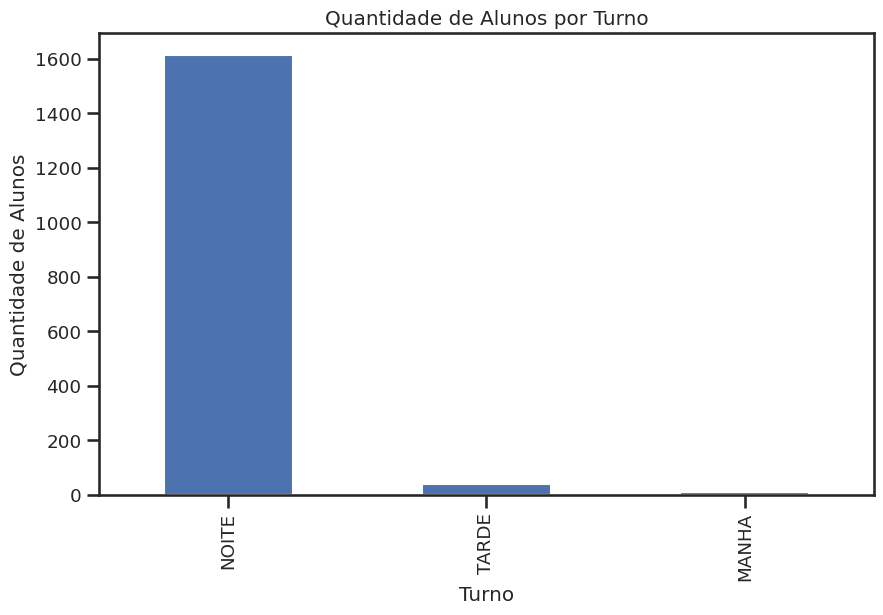

In [60]:
style_countsT = df['TURNO'].value_counts()

# Plote o gráfico de barras
plt.figure(figsize=(10, 6))
style_countsT.plot(kind='bar')
plt.title('Quantidade de Alunos por Turno')
plt.xlabel('Turno')
plt.ylabel('Quantidade de Alunos')
plt.show()

In [61]:
contingency_tableT = pd.crosstab(df['TURNO'], df['ESTILOS'])

In [62]:
chi2, p, dof, expected = chi2_contingency(contingency_tableT)
cramer_vT = math.sqrt(chi2 / (df.shape[0] * df.shape[1] * (dof - 1)))

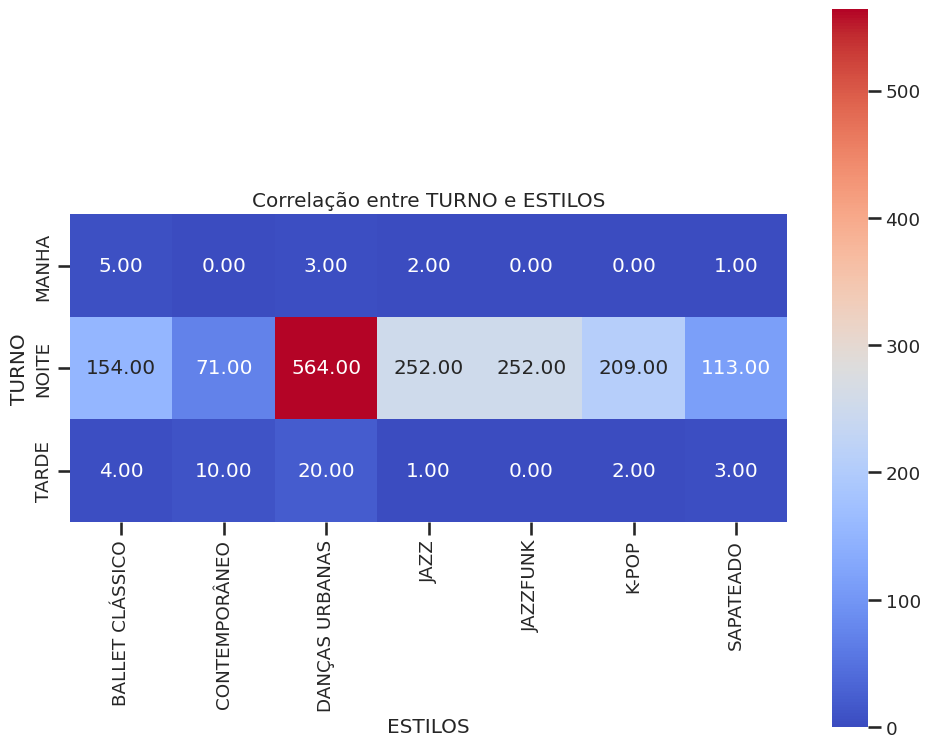

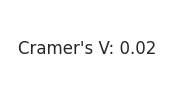

In [63]:
plt.figure(figsize=(10, 8))
sns.heatmap(contingency_tableT, annot=True, cmap='coolwarm', square=True, fmt='.2f')
plt.title('Correlação entre TURNO e ESTILOS')
plt.tight_layout()
plt.show()

plt.figure(figsize=(2, 1))
plt.text(0.5, 0.5, f'Cramer\'s V: {cramer_vT:.2f}', ha='center', va='center', fontsize=12)
plt.axis('off')
plt.show() # Cramer's V é: 0.02 associação fraca entre as variáveis turno e estilos

In [64]:
df.head(5)

,DATA 1º CONTATO,NOME COMPLETO,IDADE,FAIXA ETARIA,TELEFONE,STATUS,VIA,ESTILOS,DATA AGENDAMENTO,TURNO,PROFESSOR,COMPARECEU,REAGENDAMENTO,SITUAÇÃO,OBSERVAÇÕES
0,2022-01-07,GRAZIELE,22,ADULTO,0000-0000,EXPERIMENTAL,WHATSAPP,JAZZFUNK,NaT,NOITE,ALISSON,SIM,NÃO,MATRICULADO,NaN
1,2022-01-07,CAMILA,19,ADULTO,0000-0000,CAPTAÇÃO,WHATSAPP,JAZZ,NaT,NOITE,LIA,NÃO,NÃO,SEMANA SOLIDÁRIA,NaN
2,2021-01-05,MAIARA GOUVEA,16,ADULTO,0000-0000,EXPERIMENTAL,WHATS,K-POP,NaT,NOITE,ALISSON,NÃO,NÃO,DESISTIU,NaN
3,2021-01-05,ENIALE RAMOS QUINTINO MÃE ELAINE,11,ADOLESCENTE,0000-0000,EXPERIMENTAL,WHATS,JAZZ,NaT,NOITE,LIA,SIM,NÃO,MATRICULADO,NaN
4,2022-01-07,BIA,19,ADULTO,0000-0000,CAPTAÇÃO,WHATSAPP,DANÇAS URBANAS,NaT,NOITE,NÃO INFORMADO,NÃO,NÃO,SEMANA SOLIDÁRIA,NaN


<h1><font size="4" color="#FF69B4">Exportação arquivo</font></h1>

<p><font size="3">Exportar o arquivo com as formatações e filtros.</font></p>

In [65]:
# Exportar um arquivo xlsx com as formatações/filtros
# Configurações de formatação
header_format = {
    'bold': True,
    'font_size': 12,
    'align': 'center',
    'valign': 'vcenter',
    'fg_color': '#D3D3D3',
    'border': 1
}

cell_format = {
    'font_size': 11,
    'align': 'center',
    'valign': 'vcenter',
    'border': 1
}

# Crie o objeto ExcelWriter
with pd.ExcelWriter('CRM.xlsx', engine='xlsxwriter') as writer:
    # Exporte o DataFrame para o arquivo xlsx
    df.to_excel(writer, sheet_name='CRM', index=False)

    # Formate a planilha
    workbook = writer.book
    worksheet = writer.sheets['CRM']

    # Adicione o filtro ao cabeçalho
    worksheet.autofilter(0, 0, 0, len(df.columns) - 1)

    # Formatação do cabeçalho
    header_format_obj = workbook.add_format(header_format)
    for col_num, value in enumerate(df.columns.values):
        worksheet.write(0, col_num, value, header_format_obj)

    # Formatação das células
    cell_format_obj = workbook.add_format(cell_format)
    date_format_obj = workbook.add_format({'num_format': 'yyyy-mm-dd', 'border': 1})

    for row_num, row_data in enumerate(df.values):
        for col_num, value in enumerate(row_data):
            if pd.isnull(value):
                worksheet.write(row_num + 1, col_num, '', cell_format_obj)
            elif col_num == 0:
                worksheet.write(row_num + 1, col_num, value, date_format_obj)
            else:
                worksheet.write(row_num + 1, col_num, value, cell_format_obj)

    # Ajuste a largura das colunas
    for col_num, col_width in enumerate([20, 20, 20]):
        worksheet.set_column(col_num, col_num, col_width)

    # Descomente a linha abaixo se você tiver outro DataFrame para exportar
    # df_pc.to_excel(writer, sheet_name='Plano de contas', index=False)